In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import csv
from scipy.stats import kde
import seaborn as sns
import scipy.stats as stats
from IPython.display import HTML, display
from datetime import datetime
import statsmodels.formula.api as smf

In [7]:
#The two truck data set paths are set here.
truck1csv = "../data/trucks/truck1.csv"
truck2csv = "../data/trucks/truck2.csv"

#The two column header dictonary paths are set here.
truck1dictcsv = "../data/dictionary/truck1dict.csv"
truck2dictcsv = "../data/dictionary/truck2dict.csv"

#Number of records desired from the data set.
numberOfRecords = 100

#If the number of values that are NOT Na type pass this percentage, the row will be deleted
rowNaNThresholdPercent = 75

#Create column conversion dictionaries from CSV files.
truck1dict={}
truck2dict={}
with open(truck1dictcsv, 'r') as f:
    for row in csv.reader(f):
        truck1dict.update({row[0]:row[1]})
        
with open(truck2dictcsv, 'r') as f:
    for row in csv.reader(f):
        truck2dict.update({row[0]:row[1]})
        
def readCsv(truck):
    return pd.read_csv(truck, header = [0])
    
def cullUtcCols(truckData):
    noUTC = truckData.drop(["UTC hour", "UTC minute", "UTC second", "UTC month", "UTC day", "UTC year"], axis = 1)
    return noUTC

"""Takes a DataFrame and a conversion dictionary as parameters;
    uses the dictionary to rename all matching columns then returns the changed DataFrame."""
def renameColumns(dataFrame, dictionary):
    return dataFrame.rename(columns = dictionary)

"""Finds threshold of Non-NA type using percentage and deletes rows."""
def removeUnnecessaryRows(dataFrame):
    length = len(dataFrame.columns)
    TValue = (rowNaNThresholdPercent / 100) * length
    print("Threshold value: " + str(int(TValue)))
    return dataFrame.dropna(thresh = int(TValue))

"""Finds columns with all Na types and deletes them."""
def removeUnnecessaryColumns(dataFrame):
    return dataFrame.dropna(axis=1, how='all')

# NOTE: The following function is unused in this notebook, but it can be used to convert CSV files into
# conversion dictionaries i.e. creating the column rename dictionaries, which was manually done in the
# previous block manually.

"""Creates a Python dictionary from a pre-defined CSV dictionary.
This will only look at the first two columns of the given CSV file."""
def createPythonDictionary(dictionaryCSV):
    # Initialize the resulting dictionary.
    dictResult = {}
    
    # Opens the passed in CSV which defines the rename dictionary and iterates through it to store each value into a Python dictionary.
    with open(dictionaryCSV, 'r') as f:
        for row in csv.reader(f):
            dictResult.update({row[0]:row[1]})
    return dictResult


#For the function divideByDay() make sure to pass in a DataFrame of a truck. 
#If you want specific column of data then just specify it by using quotation and the accurate name of the column. 
#Example: This line will get daily averages for all columns: print(divideByDay(truck1data) 
#This line will get daily average of speed: print(divideByDay(truck1data, "Speed (km/hr)"))

def divideByDay(truck_df, byday_df=None):
    dates = []
    #truck_df = truck_df.head()
    for index, tdata in truck_df.iterrows():
        dates.append(tdata['Time (DateTime)'].split(' ')[0])
        #print(index, dates)
        
    truck_df['Time (DateTime)'] = dates
    
    if(byday_df):
        byday_df = truck_df.groupby('Time (DateTime)')[byday_df].mean()
    else:
        byday_df = truck_df.groupby('Time (DateTime)').mean()

    return byday_df

## Same use as divideByDay() but needs second parameter!! If no parameter given, error will be thrown.
def outlierDetection(truck_df, column_attribute):
    
    iterateData = 0
    fiveNum = [truck_df[column_attribute].quantile(0), truck_df[column_attribute].quantile(.25), truck_df[column_attribute].quantile(.5), truck_df[column_attribute].quantile(.75), truck_df[column_attribute].quantile(1)]
    iqr = fiveNum[3] - fiveNum[1]
    low_outl = fiveNum[1] - (1.5 * iqr)
    high_outl = fiveNum[3] + (1.5 * iqr)
    print("Before Outlier Deletion: " + str(fiveNum))
    print("Low bound: " + str(low_outl))
    print("High bound: " + str(high_outl))
 
    truck_df = truck_df[(truck_df[column_attribute] > low_outl)]
    truck_df = truck_df[(truck_df[column_attribute] < high_outl)]
    fiveNum = [truck_df[column_attribute].quantile(0), truck_df[column_attribute].quantile(.25), truck_df[column_attribute].quantile(.5), truck_df[column_attribute].quantile(.75), truck_df[column_attribute].quantile(1)]
    #iqr = fiveNum[3] - fiveNum[1]
    #low_outl = fiveNum[1] - (1.5 * iqr)
    #high_outl = fiveNum[3] + (1.5 * iqr)
    print("After Outlier Deletion: " + str(fiveNum))

    sns.boxplot(x=truck_df[column_attribute], showfliers=False)
    
    return truck_df


In [8]:
# Data cleaning for Machine learning
truck1data = readCsv(truck1csv)
truck1data = cullUtcCols(truck1data)
#truck1data = removeUnnecessaryRows(truck1data)
truck1data = renameColumns(truck1data, truck1dict)
truck1data = removeUnnecessaryColumns(truck1data)

truck2data = readCsv(truck2csv)
truck2data = cullUtcCols(truck2data)
#truck2data = removeUnnecessaryRows(truck2data)
truck2data = renameColumns(truck2data, truck2dict)
truck2data = removeUnnecessaryColumns(truck2data)

In [9]:
# Data for dividing day mean for outside temp
truck1data_c = readCsv(truck1csv)
truck1data_c = cullUtcCols(truck1data_c)
truck1data_c = removeUnnecessaryRows(truck1data_c)
truck1data_c = renameColumns(truck1data_c, truck1dict)
truck1data_c = removeUnnecessaryColumns(truck1data_c)

truck2data_c = readCsv(truck2csv)
truck2data_c = cullUtcCols(truck2data_c)
truck2data_c = removeUnnecessaryRows(truck2data_c)
truck2data_c = renameColumns(truck2data_c, truck2dict)
truck2data_c = removeUnnecessaryColumns(truck2data_c)

Threshold value: 33
Threshold value: 30


In [10]:
outside_air_temp = divideByDay(truck1data_c, 'Outside Air Temperature (C)')

In [ ]:
divideByDay(truck1data, "Oil Temperature (C)")

In [12]:
def datetimeToSeconds(indTo, indTill):
    FMT = '%m/%d/%Y %H:%M:%S.%f'

    d1 = datetime.strptime(str(truck1data['Time (DateTime)'][indTill]), FMT)

    #print(d1)

    d2 = datetime.strptime(str(truck1data['Time (DateTime)'][indTo]), FMT)

    #print(d2)

    return (d1-d2).total_seconds()
    
    

print(datetimeToSeconds(338, 27241))

18381.241


In [ ]:
t2_oiltemp = divideByDay(truck2data, "Oil Temperature (C)")

In [60]:
def detectIdeal(truck_df):
    df_list = np.split(truck_df, truck_df[truck_df.isnull().all(1)].index) 
    valid_df_list = []
    for tdf in df_list:
        #if datetimeToSeconds(df_list.index.start, df_list.index.stop)
        #df_list.index.start
        
        #print(tdf["Oil Temperature (C)"])
        truck_ses_temp_diff = tdf["Oil Temperature (C)"][tdf.index.stop - 1] - tdf["Oil Temperature (C)"][tdf.index.start + 1] 
        
        truck_ses_sec = datetimeToSeconds(tdf.index.start + 1, tdf.index.stop - 1)
        #print(truck_ses_sec)
        #print(truck_ses_temp_diff)
        
        # If the session the truck has been turned on is greater than 600 seconds then proceeds 
        if truck_ses_sec > 600:
        # If the session for the truck has less than 30 degrees (C) difference from start to end then dont add to valid list
            if truck_ses_temp_diff > 30:
                valid_df_list.append(tdf)
    
    return valid_df_list
    #print(df_list)
        

In [ ]:
detectIdeal(truck1data) 

In [66]:
df_list = np.split(truck1data, truck1data[truck1data.isnull().all(1)].index) 
def getIdealData():
    min_temp_df = []
    time_temp_data = []
    seconds_df = []
    outside_temp_df = []
    for truck_df in detectIdeal(truck1data):
        ideal_temp = truck_df["Oil Temperature (C)"].mean()
        min_temp_df = truck_df[truck_df["Oil Temperature (C)"] == truck_df["Oil Temperature (C)"].min()]["Time (DateTime)"]
        #print(min_temp_df.index[0])
        
        ideal_df = truck_df.loc[truck_df['Oil Temperature (C)'] >= ideal_temp]['Oil Temperature (C)']
        #print(ideal_df.index[1])
        #print(truck_df['Time (DateTime)'].iloc[1].split(' ')[0])
        sec = datetimeToSeconds(min_temp_df.index[0], ideal_df.index[1])
        out_temp = outside_air_temp[truck_df['Time (DateTime)'].iloc[1].split(' ')[0]]
        seconds_df.append(sec)
        outside_temp_df.append(out_temp)
        #print(datetimeToSeconds(min_temp_df.index[0], ideal_df.index[1]))
        time_temp_data.append([sec, out_temp])
    #print(seconds_df)
    time_temp_data_df = pd.DataFrame(np.array(time_temp_data), columns=['Seconds', 'OutsideTemperature'])
    #print(time_temp_data_df)
    return time_temp_data_df

Intercept            -3429.549766
OutsideTemperature     177.357709
dtype: float64

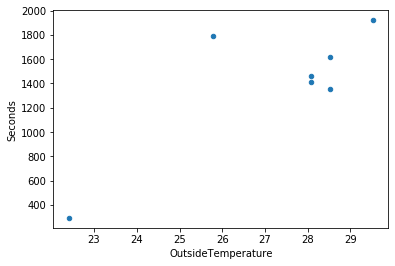

In [91]:
df_data = getIdealData()

df_data.plot(kind='scatter', x='OutsideTemperature', y='Seconds')

lm = smf.ols(formula='Seconds ~ OutsideTemperature', data=df_data).fit()

lm.params

In [92]:
predict_val = pd.DataFrame({'OutsideTemperature': [20, 30]})


preds = lm.predict(predict_val)
preds

0     117.604418
1    1891.181511
dtype: float64

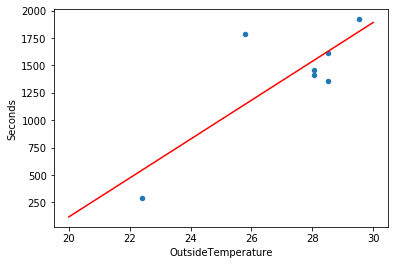

In [95]:
df_data.plot(kind='scatter', x='OutsideTemperature', y='Seconds')
#plt.margins() 
plt.plot(predict_val, preds, c='red')